# Random Forrest Model Assessment

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import make_pipeline


## Import training data

In [2]:
X_train = pd.read_csv('../data/X_train_trans.csv', index_col=0)

pickle_in = open('../data/y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)

## Confusion Matrix Function

In [3]:
#creating a confusion matrix template
import warnings
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10, 5]

# from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Random Forrest Classification

In [4]:
clf = RandomForestClassifier(n_jobs=-1, bootstrap=True)
clf.fit(X_train, y_train);

In [5]:
clf.decision_path(X_train);

In [6]:
clf.feature_importances_;

Confusion Matrix, without normalization
[[1995    0]
 [   0  338]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1995
           1       1.00      1.00      1.00       338

    accuracy                           1.00      2333
   macro avg       1.00      1.00      1.00      2333
weighted avg       1.00      1.00      1.00      2333

roc_auc_score: 1.0


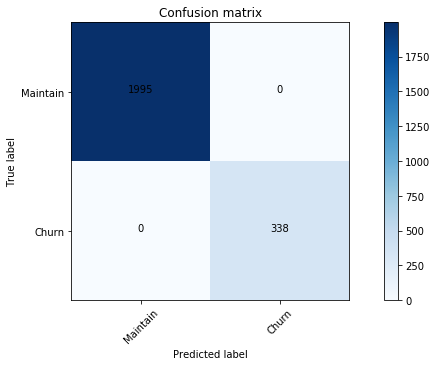

In [7]:
y_pred = clf.predict(X_train)

cm = confusion_matrix(y_train, y_pred)
classes = ['Maintain', 'Churn']
plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix')

#Checking performance our model with classification report.
print(classification_report(y_train, y_pred))
#Checking performance our model with ROC Score.
print ('roc_auc_score:', roc_auc_score(y_train, y_pred))

In [8]:
# print('Precision: {}\nAccuracy: {}\nRecall: {}\nF1: {}'.format(precision_score(y_train, y_pred), 
#                 accuracy_score(y_train, y_pred), 
#                 recall_score(y_train, y_pred), 
#                 f1_score(y_train, y_pred)))

In [9]:
cvs = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'precision')
print('Average CV score: {}'.format(np.average(cvs)))

Average CV score: 1.0


In [10]:
max_features = len(X_train.columns)
np.sqrt(max_features), np.log2(max_features)

(4.69041575982343, 4.459431618637297)

In [11]:
params = {'n_estimators': [50, 100, 250, 500],
          'max_depth': [3, 4, 5, 7],
          'min_samples_leaf': [50, 100, 250, 500],
          'max_features': ['sqrt', 'log2', 'auto']
}

In [12]:
gscv = GridSearchCV(clf, params, n_jobs = -1, verbose = 1)
gscv.fit(X_train, y_train)

# sorted(gscv.cv_results_.keys())

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              rand

In [13]:
gscv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [14]:
results = pd.DataFrame(gscv.cv_results_)
results[['rank_test_score', 'mean_test_score', 'param_max_depth',
         'param_max_features', 'param_min_samples_leaf', 'param_n_estimators']].\
            sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_test_score,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators
160,1,0.891127,7,log2,50,50
161,2,0.890698,7,log2,50,100
112,3,0.890696,5,log2,50,50
177,4,0.890269,7,auto,50,100
66,5,0.889840,4,log2,50,250


In [15]:
gscv.cv_results_['params'][gscv.best_index_]

{'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 50,
 'n_estimators': 50}

In [16]:
gscv.cv_results_['mean_test_score'][gscv.best_index_]

0.8911268162226245

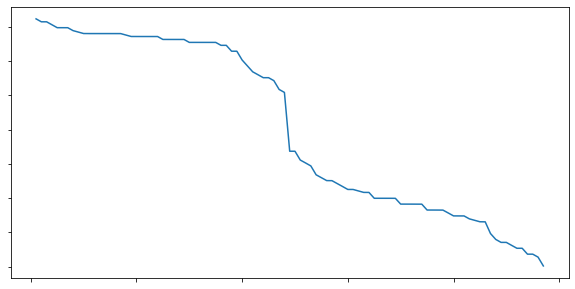

In [17]:
sns.lineplot(x = results.rank_test_score, y = results.mean_test_score)

In [18]:
max_d = gscv.cv_results_['param_max_depth'][gscv.best_index_]
max_f = gscv.cv_results_['param_max_features'][gscv.best_index_]
min_samp = gscv.cv_results_['param_min_samples_leaf'][gscv.best_index_]
n_est = gscv.cv_results_['param_n_estimators'][gscv.best_index_]

### Model with best features:

In [19]:
print('- max_depth: {}\n- max_features: {}\n- min_samples_leaf: {}\n- n_estimators: {}'\
      .format(max_d, max_f, min_samp, n_est))

- max_depth: 7
- max_features: log2
- min_samples_leaf: 50
- n_estimators: 50


In [20]:
best = RandomForestClassifier(max_depth=max_d,
                              max_features=max_f,
                              min_samples_leaf=min_samp,
                              n_estimators=n_est,
                              n_jobs=-1)
best.fit(X_train, y_train);

In [21]:
y_pred = best.predict(X_train)

In [22]:
precision_score(y_train, y_pred)

0.7971014492753623

### Cross-validation of best model

In [23]:
cv = cross_val_score(best, X_train, y_train, cv = 5, scoring = 'precision')

In [24]:
cv.mean()

0.8267422232939475

In [25]:
cv10 = cross_val_score(best, X_train, y_train, cv = 10, scoring = 'precision')

In [26]:
feats = list(zip(X_train.columns, best.feature_importances_))

### Top 5 Important Features

In [27]:
pd.DataFrame(feats, columns = ['feature', 'importance']).\
                                sort_values(by = 'importance', ascending = False).head(5)

,feature,importance
17,total_charge,0.272368
2,total_day_minutes,0.168897
14,customer_service_calls,0.166649
4,total_day_charge,0.114613
20,x1_yes,0.089013


### Review all test scores

In [28]:
all_results = {'test': ['grid_search', 'best_model', 'best_cv_5', 'best_cv_10'], 
              'score': [gscv.cv_results_['mean_test_score'][gscv.best_index_],
                        precision_score(y_train, y_pred), 
                        cv.mean(), 
                        cv10.mean()]}

In [29]:
pd.DataFrame(all_results)

,test,score
0,grid_search,0.891127
1,best_model,0.797101
2,best_cv_5,0.826742
3,best_cv_10,0.823462
